In [2]:
import numpy as np
import pandas as pd
import re
import os

import skimage.io
import skimage.segmentation
import matplotlib.pyplot as plt
from glob import glob

import cv2

cwd = os.getcwd()
print(cwd)

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

py.init_notebook_mode(connected=True)

/medical_data/zhuoyao_workspace/final_medical_cervix_2/tools


In [3]:
DATASET_DIR = os.path.join(cwd,'../../Datasets/herlev_cells/smear2005/')
IMG_DIR = os.path.join(DATASET_DIR,'New database pictures')
XLS_PATH = os.path.join(DATASET_DIR,'new_database_results.xls')

FOLDERS = ['normal_superficiel','normal_intermediate',\
           'normal_columnar','light_dysplastic',\
           'moderate_dysplastic','severe_dysplastic',\
           'carcinoma_in_situ'
           ]

CLASS = ['normal_superficiel','normal_intermediate',\
           'normal_columnar','light_dysplastic',\
           'moderate_dysplastic','severe_dysplastic',\
           'carcinoma_in_situ'
           ]

In [4]:
os.listdir(IMG_DIR)

['normal_columnar',
 'moderate_dysplastic',
 'carcinoma_in_situ',
 'light_dysplastic',
 'normal_intermediate',
 'severe_dysplastic',
 'normal_superficiel']

In [5]:
herlev_df = pd.read_excel(XLS_PATH)

In [6]:
herlev_df.head()

,ID,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,...,CytoElong,CytoRund,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin,Class
0,153958345-153958392-001.BMP,803.500,27804.125,0.028087,85.866083,192.524631,29.832191,34.828150,0.856554,0.843403,...,0.750175,0.604273,101.375,673.500,0.230067,44,37,649,655,1
1,153960256-153960295-002.BMP,610.125,18067.875,0.032665,81.531353,153.439838,25.319871,30.805844,0.821918,0.818583,...,0.866065,0.589351,85.250,597.000,0.043701,36,26,502,504,1
2,157181281-157181308-001.BMP,990.375,79029.875,0.012377,77.843655,118.001177,33.552901,38.327536,0.875425,0.858397,...,0.815760,0.794843,111.750,1059.125,0.141150,53,37,2267,2500,1
3,157181387-157181418-001.BMP,554.500,98941.000,0.005573,70.054545,139.359845,23.799254,29.832868,0.797753,0.793271,...,0.770601,0.695414,81.000,1264.500,0.079801,38,29,2885,2960,1
4,157181525-157181540-001.BMP,636.375,99663.250,0.006345,76.950949,137.748293,25.946189,31.256999,0.830092,0.829332,...,1.215871,1.071126,87.875,1250.625,0.121304,36,24,2978,3159,1


In [7]:
cell_df = herlev_df[['ID','Class']].copy()
cell_df.columns = ['point','Class']
cell_df['point'] = cell_df['point'].apply(lambda x: x.split('.')[0])
for t in cell_df['Class'].unique():
    cell_df.loc[cell_df['Class']==t,'folder'] = FOLDERS[t-1]
    
cell_df['path'] = cell_df[['folder','point']].apply(lambda x: os.path.join(IMG_DIR,
                                                                x['folder'],
                                                                str(x['point'])+'.BMP'),
                                            axis=1) 
cell_df['d_path'] = cell_df[['folder','point']].apply(lambda x: os.path.join(IMG_DIR,
                                                                x['folder'],
                                                                str(x['point'])+'-d.bmp'),
                                            axis=1) 

cell_df['type'] = cell_df['Class'].apply(lambda x: int(x>3))

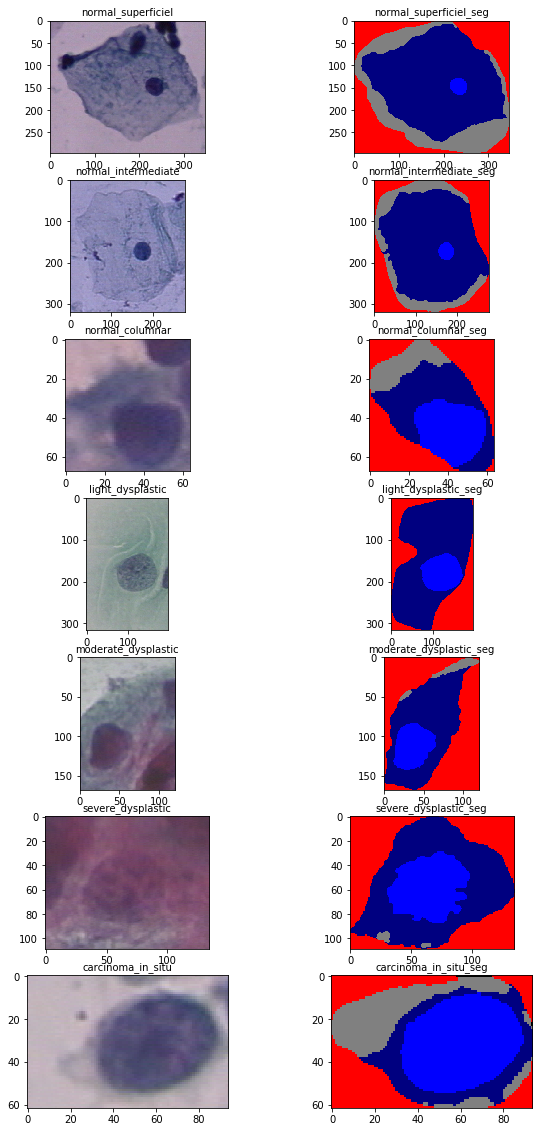

In [8]:
fig, axs = plt.subplots(nrows = 7, ncols=2, constrained_layout=False,figsize=(10,20))

def plot_img(img_path,ax,title):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(title,fontsize=10)

for t in cell_df['Class'].unique():
    index = np.random.choice(cell_df.loc[cell_df['Class']==t].index)
    img_path = cell_df.iloc[index]['path']
    img_d_path = cell_df.iloc[index]['d_path']
    ax = axs.flatten()[2*t-2]
    ax_d = axs.flatten()[2*t-1]
    
    plot_img(img_path,ax,FOLDERS[t-1])
    plot_img(img_d_path,ax_d,FOLDERS[t-1]+'_seg')
    

[  0  15  29  76 128]
0.018066295844073623
799
44226


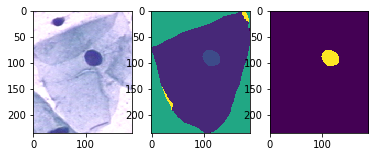

In [9]:
ind = cell_df.loc[cell_df['Class']==1].index[0]
img_path = cell_df.iloc[ind]['path']
img_d_path = cell_df.iloc[ind]['d_path']
img = cv2.imread(img_d_path,cv2.IMREAD_GRAYSCALE)
#img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_org = cv2.imread(img_path)
img_org = cv2.cvtColor(img_org,cv2.COLOR_BGR2RGB)

print(np.unique(img))
#plt.imshow(img)

img_mask = np.zeros(np.shape(img)[:2])
img_mask[np.where(img==29)]=1


fig, axs = plt.subplots(nrows=1,ncols=3)
axs[0].imshow(img_org)
axs[1].imshow(img)
axs[2].imshow(img_mask)

print(np.sum(img==29)/(img.shape[0]*img.shape[1]))

print(np.sum(img==29))
print(img.shape[0]*img.shape[1])
#plt.imshow(img_mask)
#plt.imshow(img_org)

**Class Statistics**

In [10]:
tmp = cell_df[['point','Class']].groupby('Class').count()

trace1 = go.Bar(
    x=FOLDERS,
    y=tmp['point'].values,
    name='Abnormal'
)


data = [trace1]

fig = go.Figure(data=data)
py.iplot(fig)

In [11]:
def get_features(imag_path):
    #cv2 read, return in BGR order
    img = cv2.imread(imag_path)
    #shape
    height = img.shape[0]
    width = img.shape[1]
    ratio = width/height
    area = height*width
    #color
    max_b = np.max(img[:,:,0])
    min_b = np.min(img[:,:,0])
    max_g = np.max(img[:,:,1])
    min_g = np.min(img[:,:,1])
    max_r = np.max(img[:,:,2])
    min_r = np.min(img[:,:,2])
    
    mean_b = np.mean(img[:,:,0])
    mean_g = np.mean(img[:,:,1])
    mean_r = np.mean(img[:,:,2])
    
    #del img
    #gc.collect()
    
    
    return (height,width,ratio,area,max_b,min_b,max_g,min_g,max_r,min_r,mean_b,mean_g,mean_r)

def get_core_ratio(img_d_path):
    img = cv2.imread(img_d_path,cv2.IMREAD_GRAYSCALE)
    area = img.shape[0]*img.shape[1]
    core_area = np.sum(img==29)
    
    core_ratio = core_area/area
    
    return core_ratio

In [12]:
features = ['h','w','ratio','area','max_blue','min_blue',\
            'max_green','min_green','max_red','min_red',\
            'mean_blue','mean_green','mean_red','core_ratio']

temp = list(zip(*cell_df['path'].map(get_features)))+\
        [list(cell_df['d_path'].map(get_core_ratio))]
for i,f in enumerate(features):
    cell_df[f] = temp[i]

In [13]:
cell_df.head()

,point,Class,folder,path,d_path,type,h,w,ratio,area,max_blue,min_blue,max_green,min_green,max_red,min_red,mean_blue,mean_green,mean_red,core_ratio
0,153958345-153958392-001,1,normal_superficiel,/medical_data/zhuoyao_workspace/final_medical_...,/medical_data/zhuoyao_workspace/final_medical_...,0,234,189,0.807692,44226,255,125,255,53,255,54,233.902229,195.935377,196.772442,0.018066
1,153960256-153960295-002,1,normal_superficiel,/medical_data/zhuoyao_workspace/final_medical_...,/medical_data/zhuoyao_workspace/final_medical_...,0,168,171,1.017857,28728,255,110,241,38,255,69,200.386278,147.558723,206.992029,0.021094
2,157181281-157181308-001,1,normal_superficiel,/medical_data/zhuoyao_workspace/final_medical_...,/medical_data/zhuoyao_workspace/final_medical_...,0,280,355,1.267857,99400,185,54,195,48,201,54,122.472153,106.520744,147.901791,0.009909
3,157181387-157181418-001,1,normal_superficiel,/medical_data/zhuoyao_workspace/final_medical_...,/medical_data/zhuoyao_workspace/final_medical_...,0,300,768,2.560000,230400,197,31,209,43,213,43,151.221541,150.893850,167.159023,0.002387
4,157181525-157181540-001,1,normal_superficiel,/medical_data/zhuoyao_workspace/final_medical_...,/medical_data/zhuoyao_workspace/final_medical_...,0,393,349,0.888041,137157,185,57,193,45,197,71,141.852826,136.686950,163.353340,0.004608


In [14]:
def plot_gen_data(norm_data, abnorm_data):
    trace1 = go.Histogram(
        x=norm_data,
        opacity=0.75,
        name='Norm_cell'
    )

    trace2 = go.Histogram(
        x=abnorm_data,
        opacity=0.75,
        name='Abnorm_cell'
    )
    
    return [trace1,trace2]

def visual_statics(df,features,title):
    fig = tools.make_subplots(rows=(len(features)//2+1),cols=2,subplot_titles=features)

    for i,f in enumerate(features):
        norm = df.loc[df['type']==0][f]
        abnorm = df.loc[df['type']==1][f]
        trace_norm,trace_abnorm = plot_gen_data(norm,abnorm)
    
        fig.append_trace(trace_norm,i//2+1,i%2+1) 
        fig.append_trace(trace_abnorm,i//2+1,i%2+1) 
    
    fig['layout'].update(height=1500,width=1000,title=title,barmode='overlay')
    py.iplot(fig)

In [15]:
visual_statics(cell_df,features,'All cells')

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]  
[ (2,1) x3,y3 ]    [ (2,2) x4,y4 ]  
[ (3,1) x5,y5 ]    [ (3,2) x6,y6 ]  
[ (4,1) x7,y7 ]    [ (4,2) x8,y8 ]  
[ (5,1) x9,y9 ]    [ (5,2) x10,y10 ]
[ (6,1) x11,y11 ]  [ (6,2) x12,y12 ]
[ (7,1) x13,y13 ]  [ (7,2) x14,y14 ]
[ (8,1) x15,y15 ]  [ (8,2) x16,y16 ]



In [16]:
correlation_matrix = cell_df[features+['type']].corr()
trace=go.Heatmap(z=correlation_matrix.values,
                x=features+['type'],
                y=features+['type'])

data=[trace]
py.iplot(data)

In [17]:
import keras

from keras.models import Model
#from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [18]:
def inceptionv3(img_dim):
    input_tensor = Input(shape=img_dim)
    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=img_dim)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    model.summary()
    return model

In [19]:
filepath = 'src/CLASSIFY/inceptionV3_final_1/inception.fold_1.hdf5'
file = os.path.join(cwd,'../',filepath)
img_size = (299,299)

print(os.path.exists(file))
a = inceptionv3((299,299,3))
a.load_weights(filepath = file )

intermediate_layer_model = Model(inputs=a.get_layer('input_1').input,
                                outputs=a.get_layer('global_average_pooling2d_1').input)
intermediate_layer_model.summary()

True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 299, 299, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 21,804,845
Trainable params: 21,770,407
Non-trainable params: 34,438
______________________________________________________

In [20]:
batch_size = 5
test_files = cell_df['path'].values

def padding(img,img_size,color):
    shape = img.shape[:-1]
    #print(img.shape,img_size)
    delta_height = img_size[0]-shape[0]
    delta_width = img_size[1]-shape[1]
    top = delta_height//2
    bottom = delta_height-top
    left = delta_width//2
    right = delta_width-left
    new_img = cv2.copyMakeBorder(img,top,bottom,left,right,cv2.BORDER_CONSTANT,value=color)
    return new_img
        #test generator   
def test_generator():
    while True:
        for start in range(0, len(test_files), batch_size):
            x_batch = []
            end = min(start + batch_size, len(test_files))
            test_batch = test_files[start:end]
            for filepath in test_batch:
                img = cv2.imread(filepath)
                img = cv2.resize(img, img_size)
                #img = padding(img,img_size,(0,0,0))
                x_batch.append(img)
            x_batch = np.array(x_batch, np.float32) / 255.
            yield x_batch
                
test_steps = np.ceil(len(test_files) / batch_size)
        
preds_test = intermediate_layer_model.predict_generator(generator=test_generator(),
                                        steps=test_steps, verbose=1)
        

184/184 [==============================] - 9s 51ms/step


In [21]:
from sklearn import decomposition
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

def random_color(seed):
    np.random.seed(seed)
    color = np.random.randint(255,size=3)
    return 'rgb'+str(tuple(color))

In [22]:
label = cell_df['Class'].values
print(np.unique(label))
print(label.shape)

[1 2 3 4 5 6 7]
(917,)


In [23]:
re_preds = np.reshape(preds_test,(preds_test.shape[0],-1))
pca = decomposition.PCA(n_components=2)
pca.fit(re_preds)

X_pca = pca.transform(re_preds)
print(X_pca.shape)

(917, 2)


In [24]:
data = []

for cell_typ,name in enumerate(CLASS):
    trace1 = go.Scatter(
        x = X_pca[label==cell_typ+1,0],
        y = X_pca[label==cell_typ+1,1],
        name = name,
        mode = 'markers',
        marker = dict(
            size = 5,
            color = random_color(cell_typ+1)
        ),
        opacity = 0.8
    )
    data.append(trace1)

py.iplot(data)

In [25]:
re_preds = np.reshape(preds_test,(preds_test.shape[0],-1))
pca = decomposition.PCA(n_components=3)
pca.fit(re_preds)

X_pca = pca.transform(re_preds)
print(X_pca.shape)

(917, 3)


In [26]:
data = []

for cell_typ,name in enumerate(CLASS):
    trace1 = go.Scatter3d(
        x = X_pca[label==cell_typ+1,0],
        y = X_pca[label==cell_typ+1,1],
        z = X_pca[label==cell_typ+1,2],
        name = name,
        mode = 'markers',
        marker = dict(
            size = 2,
            symbol='circle',
            color = random_color(cell_typ+1)
        ),
        opacity = 0.8
    )
    data.append(trace1)

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data,layout=layout)

py.iplot(fig)

## t-SNE

In [27]:
perlexity=15
n_jobs=16

In [28]:
X_tsne = TSNE(n_components=2,perplexity=perlexity,n_jobs=n_jobs).fit_transform(re_preds)

In [29]:
data = []

for cell_typ,name in enumerate(CLASS):
    trace1 = go.Scatter(
        x = X_tsne[label==cell_typ+1,0],
        y = X_tsne[label==cell_typ+1,1],
        name = name,
        mode = 'markers',
        marker = dict(
            size = 5,
            color = random_color(cell_typ*5)
        ),
        opacity = 0.8
    )
    data.append(trace1)

py.iplot(data)

In [ ]:
X_tsne = TSNE(n_components=3,perplexity=perlexity,n_jobs=n_jobs).fit_transform(re_preds)

In [ ]:
data = []

for cell_typ,name in enumerate(CLASS):
    trace1 = go.Scatter3d(
        x = X_tsne[label==cell_typ+1,0],
        y = X_tsne[label==cell_typ+1,1],
        z = X_tsne[label==cell_typ+1,2],
        name = name,
        mode = 'markers',
        marker = dict(
            size = 2,
            symbol='circle',
            color = random_color(cell_typ*5)
        ),
        opacity = 0.8
    )
    data.append(trace1)

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data,layout=layout)

py.iplot(fig)